In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/anime-faces
License(s): unknown
100% 440M/441M [00:15<00:00, 28.1MB/s]
100% 441M/441M [00:15<00:00, 29.3MB/s]


In [ ]:
!unzip -qq anime-faces.zip -d anime-faces

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [ ]:
BASE_DIR = '/content/anime-faces/data/'

In [ ]:
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [ ]:
image_paths[:5]

['/content/anime-faces/data/17256.png',
 '/content/anime-faces/data/6502.png',
 '/content/anime-faces/data/16729.png',
 '/content/anime-faces/data/5697.png',
 '/content/anime-faces/data/9275.png']

In [ ]:
image_paths.remove('/content/anime-faces/data/data')

In [ ]:
len(image_paths)

21551

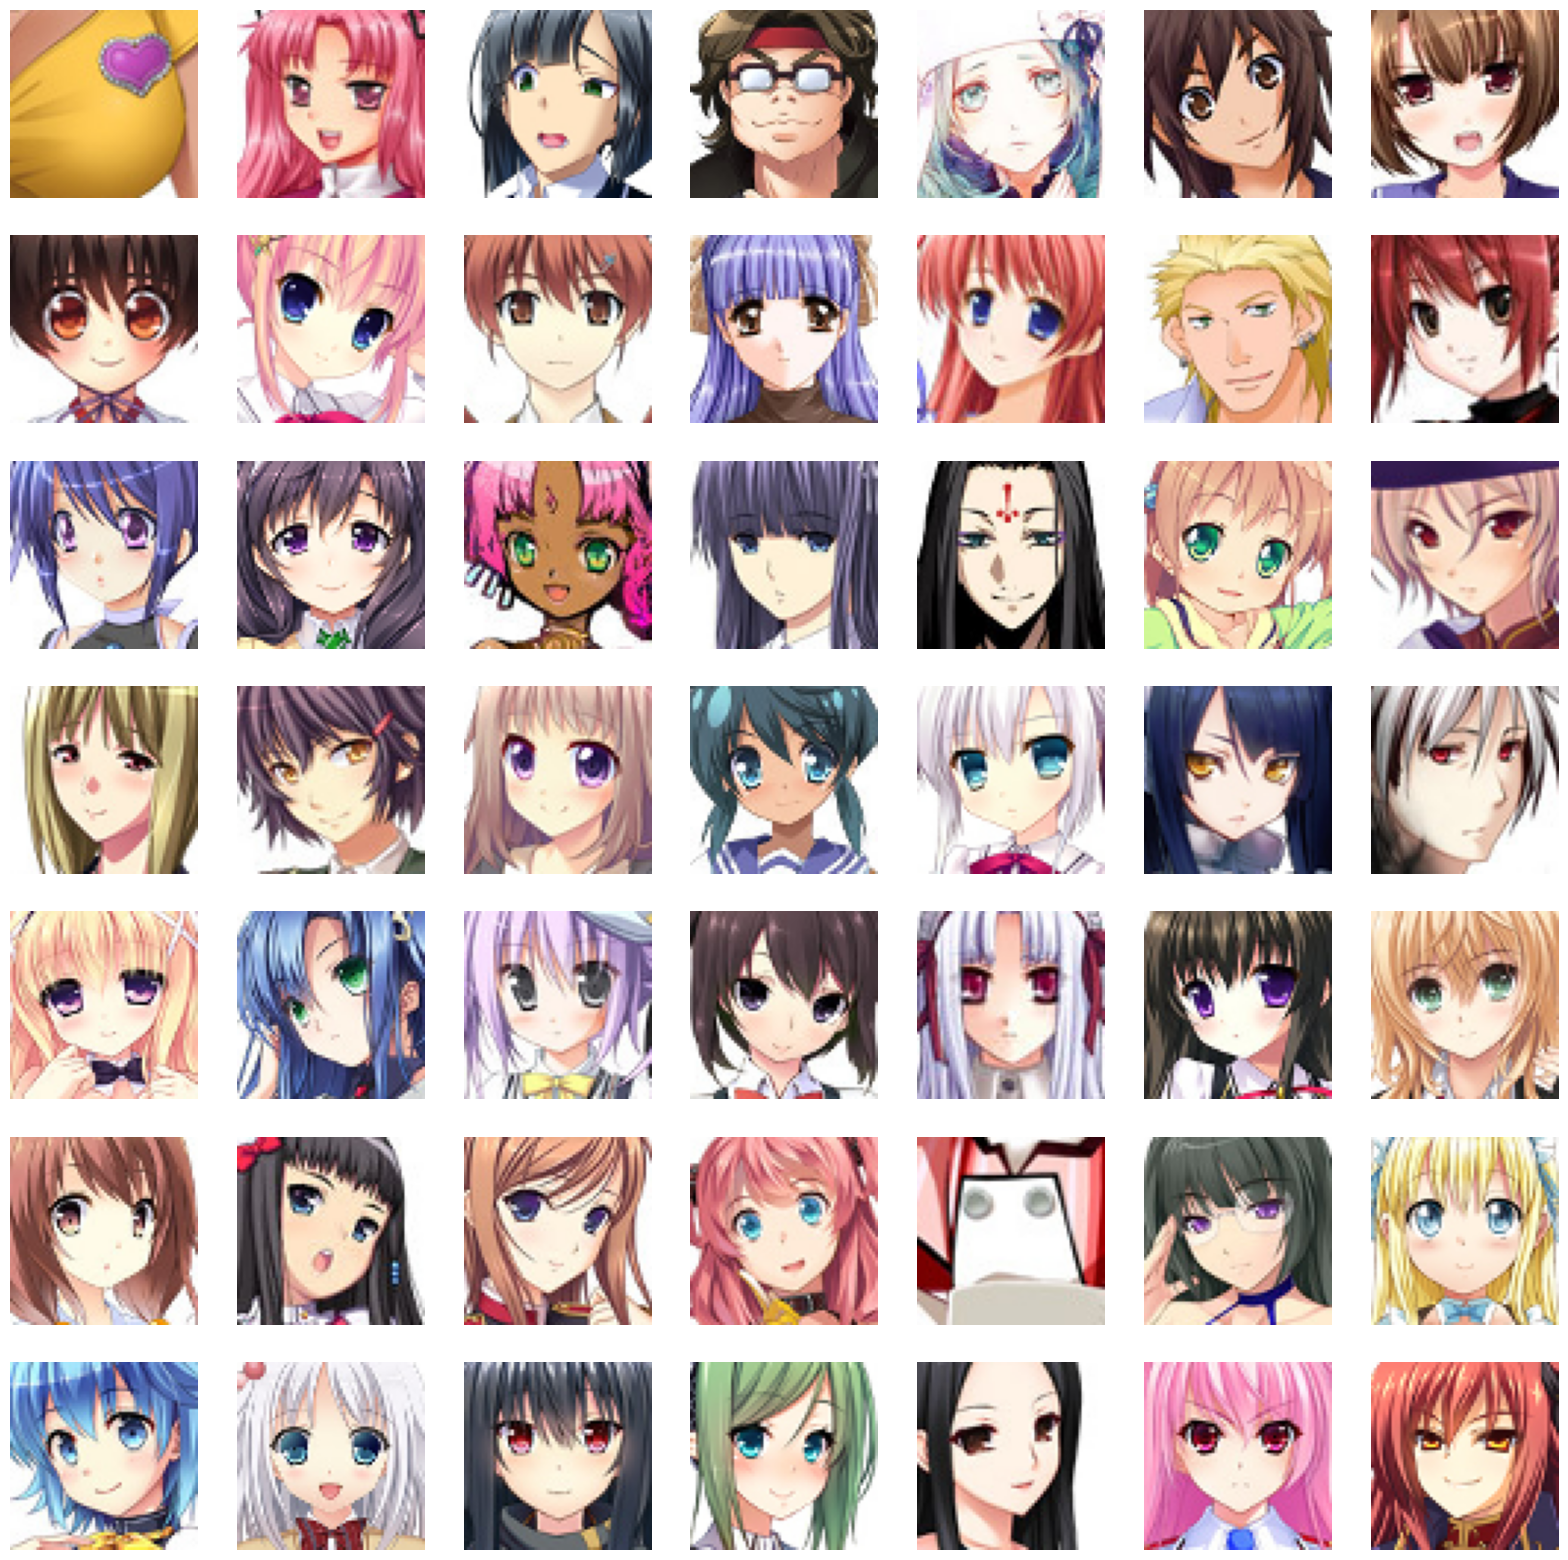

In [ ]:
plt.figure(figsize=(20,20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    img = load_img(image_path)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    index += 1

In [ ]:
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
train_images = np.array(train_images)

  0%|          | 0/21551 [00:00<?, ?it/s]

In [ ]:
train_images[0].shape

(64, 64, 3)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')

In [ ]:
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images[0]

In [ ]:
LATENT_DIM = 100
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 3

In [ ]:
model = Sequential(name='generator')
model.add(layers.Dense(8*8*512, input_dim=LATENT_DIM))
model.add(layers.ReLU())
model.add(layers.Reshape((8, 8, 512)))
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())
model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 re_lu_1 (ReLU)              (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 256)       2097408   
 Transpose)                                                      
                                                                 
 re_lu_2 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                              

In [ ]:
input_shape = (64, 64, 3)
alpha = 0.2

model = Sequential(name='discriminator')
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))
model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))
model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [ ]:
N_EPOCHS = 50
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
g_img = dcgan.generator(noise)
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()